# Import the necessary libraries

In [1]:
import os 
import re
import numpy as np
import pandas as pd
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
root_dir = "/Users/aditya/NLP/dataset"  # Replace with your actual root directory path
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")

In [3]:
def read_reviews_and_labels(directory):
    reviews = []
    labels = []
    for folder in ["pos", "neg"]:
        for filename in os.listdir(os.path.join(directory, folder)):
            filepath = os.path.join(directory, folder, filename)
            with open(filepath, 'r', encoding='utf-8') as f:
                review = f.read()
                label = int(folder == "pos")  # 1 for positive, 0 for negative
                reviews.append(review)
                labels.append(label)
    return pd.DataFrame({'review': reviews}), pd.Series(labels)

In [4]:
train_df, train_labels = read_reviews_and_labels(train_dir)

# Add sentiment labels
train_df['sentiment'] = np.where(train_labels == 1, 'positive', 'negative')

# Read test data
test_df, test_labels = read_reviews_and_labels(test_dir)

# Add sentiment labels
test_df['sentiment'] = np.where(test_labels == 1, 'positive', 'negative')

In [5]:
print("Train Data:")
#print(train_df.head())
print(f"Total train reviews: {len(train_df)}")
print(f"Positive train reviews: {train_df[train_df['sentiment'] == 'positive'].shape[0]}")
print(f"Negative train reviews: {train_df[train_df['sentiment'] == 'negative'].shape[0]}")

print("\nTest Data:")
#print(test_df.head())
print(f"Total test reviews: {len(test_df)}")
print(f"Positive test reviews: {test_df[test_df['sentiment'] == 'positive'].shape[0]}")
print(f"Negative test reviews: {test_df[test_df['sentiment'] == 'negative'].shape[0]}")

Train Data:
Total train reviews: 25000
Positive train reviews: 12500
Negative train reviews: 12500

Test Data:
Total test reviews: 25000
Positive test reviews: 12500
Negative test reviews: 12500


In [6]:
train_df.head(10)

,review,sentiment
0,For a movie that gets no respect there sure ar...,positive
1,Bizarre horror movie filled with famous faces ...,positive
2,"A solid, if unremarkable film. Matthau, as Ein...",positive
3,It's a strange feeling to sit alone in a theat...,positive
4,"You probably all already know this by now, but...",positive
5,I saw the movie with two grown children. Altho...,positive
6,You're using the IMDb.<br /><br />You've given...,positive
7,This was a good film with a powerful message o...,positive
8,"Made after QUARTET was, TRIO continued the qua...",positive
9,"For a mature man, to admit that he shed a tear...",positive


In [7]:
# check the total words in the train dataset
total_words = sum(len(row['review']) for _, row in train_df.iterrows())
average_words_per_movie = total_words / len(train_df)

# check the total words in the test dataset
total_words1 = sum(len(row['review']) for _, row in test_df.iterrows())
average_words_per_movie1 = total_words1 / len(test_df)

print(f"Total words in the train dataset: {total_words}")
print(f"Average words per movie: {average_words_per_movie:.2f}")

print(f"\nTotal words in the test dataset: {total_words1}")
print(f"Average words per movie: {average_words_per_movie1:.2f}")


Total words in the train dataset: 33126741
Average words per movie: 1325.07

Total words in the test dataset: 32344810
Average words per movie: 1293.79


In [8]:
def clean_text(text):
    # Remove unwanted characters while keeping useful punctuation
    cleaned_text = re.sub(r'\bbr\b', '', text)  # Remove standalone "br"
    cleaned_text = re.sub(r'<br\s*/?>', '', cleaned_text)  # Remove <br> tags if present
    cleaned_text = re.sub(r'[<>.*?]', '', str(text))  # Retain periods, commas, and apostrophes
    cleaned_text = re.sub(r"['’]", '', cleaned_text)  # Remove apostrophes but consider keeping contractions
    return cleaned_text.strip()

In [9]:
train_df['review'] = train_df['review'].apply(clean_text)
test_df['review'] = test_df['review'].apply(clean_text)

In [10]:
train_df.head(10)

,review,sentiment
0,For a movie that gets no respect there sure ar...,positive
1,Bizarre horror movie filled with famous faces ...,positive
2,"A solid, if unremarkable film Matthau, as Eins...",positive
3,Its a strange feeling to sit alone in a theate...,positive
4,"You probably all already know this by now, but...",positive
5,I saw the movie with two grown children Althou...,positive
6,Youre using the IMDbbr /br /Youve given some h...,positive
7,This was a good film with a powerful message o...,positive
8,"Made after QUARTET was, TRIO continued the qua...",positive
9,"For a mature man, to admit that he shed a tear...",positive


In [11]:
def remove_stop_words(text):
    # Remove non-alphabetic characters while keeping punctuation
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
    
    # Tokenization and lemmatization can proceed here, but consider retaining key terms
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words or token in ['not', 'no']]  # Retain key negations
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    return ' '.join(lemmatized_tokens)

In [12]:
train_df['review'] = train_df['review'].apply(remove_stop_words)
test_df['review'] = test_df['review'].apply(remove_stop_words)

In [13]:
train_df.head(10)

,review,sentiment
0,movie get no respect sure lot memorable quote ...,positive
1,bizarre horror movie filled famous face stolen...,positive
2,"solid , unremarkable film matthau , einstein ,...",positive
3,strange feeling sit alone theater occupied par...,positive
4,"probably already know , additional episode nev...",positive
5,saw movie two grown child although not clever ...,positive
6,youre using imdbbr br youve given hefty vote f...,positive
7,good film powerful message love redemption lov...,positive
8,"made quartet , trio continued quality earlier ...",positive
9,"mature man , admit shed tear film mature respo...",positive


## Prepare the dataset 

In [14]:
# Prepare the date
X_train = train_df['review']
y_train = train_df['sentiment']
X_test = test_df['review']
y_test = test_df['sentiment']

# Encode the sentiments
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Naive Bayes Model 

In [15]:
# Create a Naive Bayes model with a text vectorization pipeline
model = make_pipeline(CountVectorizer(), MultinomialNB())

# Train the model
model.fit(X_train, y_train_encoded)

# Make predictions
predicted = model.predict(X_test)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test_encoded, predicted)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.82


              precision    recall  f1-score   support

    negative       0.79      0.88      0.83     12500
    positive       0.87      0.77      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



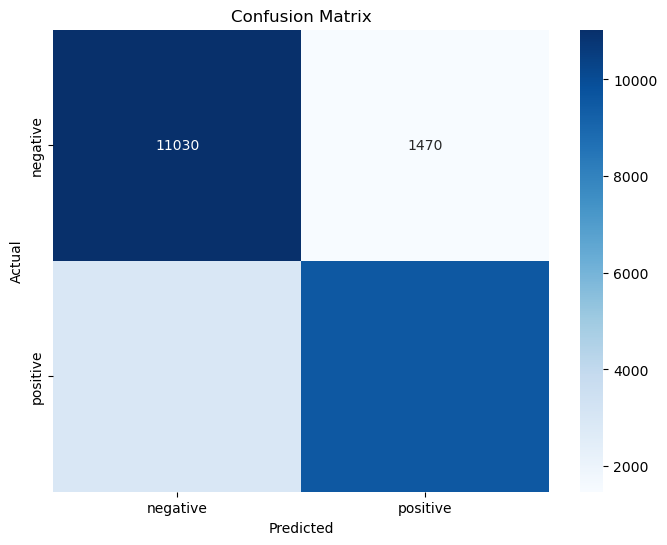

In [16]:
# Print classification report
print(metrics.classification_report(y_test_encoded, predicted, target_names=label_encoder.classes_))

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test_encoded, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## Stochastic Gradient descent 

In [17]:
sgd_pipeline = make_pipeline(
    TfidfVectorizer(max_features=1000),
    SGDClassifier(loss='hinge')  # Hinge loss for linear SVM
)

# Fit the SGD model
sgd_pipeline.fit(X_train, y_train_encoded)

# Evaluate using cross-validation
sgd_scores = cross_val_score(sgd_pipeline, X_train, y_train_encoded, cv=5, scoring='accuracy')
print("SGD Classifier Cross-Validation Accuracy:", sgd_scores.mean())

# Evaluate on the test set
sgd_test_accuracy = sgd_pipeline.score(X_test, y_test_encoded)
print("SGD Classifier Test Accuracy:", sgd_test_accuracy)

SGD Classifier Cross-Validation Accuracy: 0.8554400000000001
SGD Classifier Test Accuracy: 0.85828


              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86     12500
    Positive       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



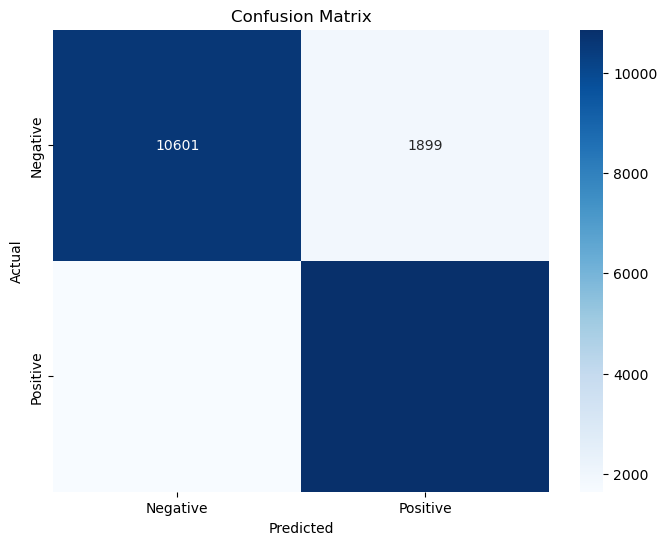

In [18]:
# Generate predictions
y_pred = sgd_pipeline.predict(X_test)

# Generate and print classification report
report = classification_report(y_test_encoded, y_pred, target_names=['Negative', 'Positive'])
print(report)

# Generate and plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Random Forest

In [19]:
rf_pipeline = make_pipeline(
    TfidfVectorizer(max_features=1000),
    RandomForestClassifier(n_estimators=100)  # You can adjust n_estimators
)

# Fit the Random Forest model
rf_pipeline.fit(X_train, y_train_encoded)

# Evaluate using cross-validation
rf_scores = cross_val_score(rf_pipeline, X_train, y_train_encoded, cv=5, scoring='accuracy')
print("Random Forest Classifier Cross-Validation Accuracy:", rf_scores.mean())

# Evaluate on the test set
rf_test_accuracy = rf_pipeline.score(X_test, y_test_encoded)
print("Random Forest Classifier Test Accuracy:", rf_test_accuracy)

Random Forest Classifier Cross-Validation Accuracy: 0.8253999999999999
Random Forest Classifier Test Accuracy: 0.82588


              precision    recall  f1-score   support

    Negative       0.82      0.83      0.83     12500
    Positive       0.83      0.82      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



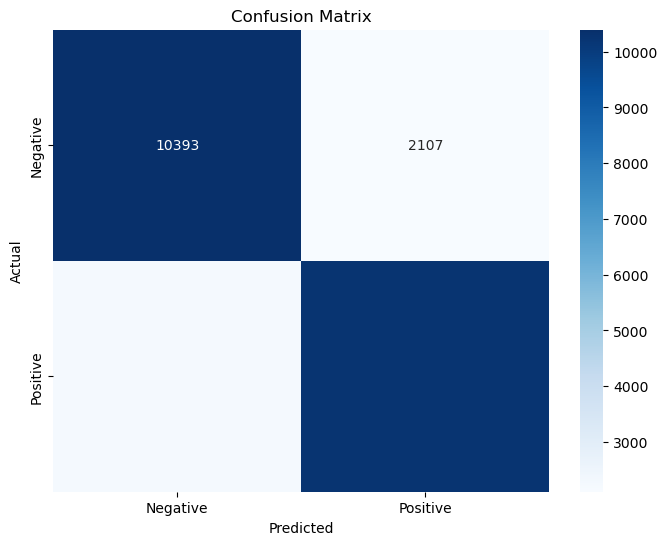

In [20]:
# Make predictions on the test set
y_pred = rf_pipeline.predict(X_test)

# Generate and print classification report
report = classification_report(y_test_encoded, y_pred, target_names=['Negative', 'Positive'])
print(report)

# Generate and plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Advance Training Step

In [21]:
# Tokenization and vocabulary creation
tokenized_reviews = [word_tokenize(review.lower()) for review in train_df['review']]
all_words = [word for review in tokenized_reviews for word in review]
vocab = Counter(all_words)
word_to_index = {word: i + 1 for i, (word, _) in enumerate(vocab.most_common())}

# Convert reviews to sequences
def review_to_sequence(review):
    indices = [word_to_index.get(word, 0) for word in review]
    return indices

X_train = [review_to_sequence(review) for review in tokenized_reviews]
y_train = [1 if sentiment == 'positive' else 0 for sentiment in train_df['sentiment']]

# Padding sequences
max_length = 100
X_train = [seq[:max_length] + [0] * (max_length - len(seq)) for seq in X_train]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Long Short Term Memory

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)  # +1 for padding
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return torch.sigmoid(out)

# Hyperparameters
embed_dim = 100
hidden_dim = 100
batch_size = 32
model = LSTMModel(len(word_to_index), embed_dim, hidden_dim, batch_size)

In [23]:

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
train_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for texts, labels in train_loader:
        model.train()
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()  # Accumulate loss for the epoch

    average_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
    train_losses.append(average_loss)  # Store the loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')   
    #print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}',)

Epoch 1/5, Loss: 0.6843
Epoch 2/5, Loss: 0.6050
Epoch 3/5, Loss: 0.4781
Epoch 4/5, Loss: 0.3284
Epoch 5/5, Loss: 0.2429


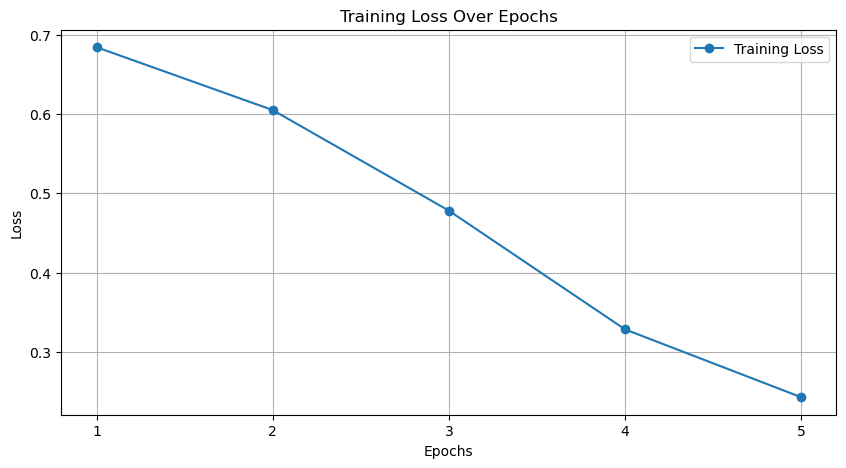

In [24]:
# Visualization of Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()
plt.show()

### Test the model

In [25]:
# Preprocess test set
tokenized_test_reviews = [word_tokenize(review.lower()) for review in test_df['review']]
X_test = [review_to_sequence(review) for review in tokenized_test_reviews]
X_test = [seq[:max_length] + [0] * (max_length - len(seq)) for seq in X_test]
y_test = [1 if sentiment == 'positive' else 0 for sentiment in test_df['sentiment']]

# Convert to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize lists for correct and incorrect predictions
correct_preds = []
incorrect_preds = []

# Store the predicted and true labels temporarily for calculating the metrics
all_true_labels = []
all_predicted_labels = []

# Evaluate
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for texts, labels in test_loader:
        outputs = model(texts)
        predicted = (outputs.squeeze() > 0.5).float()

        # Store predictions
        predicted_sentiments = np.where(predicted.cpu().numpy(), 1, 0)
        true_sentiments = labels.cpu().numpy()
        confidence_levels = outputs.squeeze().cpu().numpy()
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append to the lists
        all_true_labels.extend(true_sentiments)
        all_predicted_labels.extend(predicted_sentiments)

        
        # Store correct and incorrect predictions
        for i in range(len(labels)):
            sentiment = labels[i].item()
            prediction = predicted[i].item()
            confidence = confidence_levels[i]
            if prediction == sentiment:
                correct_preds.append((texts[i], sentiment, prediction,confidence))
            else:
                incorrect_preds.append((texts[i], sentiment, prediction, confidence))
                

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 80.54%


In [26]:
# Generate classification report using the sklearn classification_report function
print("Classification Report:")
print(classification_report(all_true_labels, all_predicted_labels, target_names=['negative', 'positive']))

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.82      0.81     12500
    positive       0.81      0.79      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [27]:
# After training the model
model.eval()
with torch.no_grad():
    outputs = model(X_train_tensor)
    predictions = (outputs.squeeze() > 0.5).float()

# Identify correct and incorrect predictions
correct_indices = (predictions == y_train_tensor).nonzero(as_tuple=True)[0]
incorrect_indices = (predictions != y_train_tensor).nonzero(as_tuple=True)[0]

# Create reverse mapping
index_to_word = {index: word for word, index in word_to_index.items()}

# Convert sequences to reviews
def sequence_to_review(sequence):
    return ' '.join(index_to_word.get(index, '') for index in sequence if index != 0)

# Retrieve incorrect reviews with predictions and actual labels
incorrect_reviews_info = []
for i in incorrect_indices:
    review_text = sequence_to_review(X_train[i])
    predicted_label = predictions[i].item()  # Get the predicted label (0 or 1)
    actual_label = y_train_tensor[i].item()  # Get the actual label
    incorrect_reviews_info.append((review_text, predicted_label, actual_label))

# Retrieve correct reviews with predictions and actual labels
correct_reviews_info = []
for i in correct_indices:
    review_text = sequence_to_review(X_train[i])
    predicted_label = predictions[i].item()  # Get the predicted label (0 or 1)
    actual_label = y_train_tensor[i].item()  # Get the actual label
    correct_reviews_info.append((review_text, predicted_label, actual_label))

# Select 5 random correct and incorrect reviews
selected_correct_reviews = random.sample(correct_reviews_info, min(5, len(correct_reviews_info)))
selected_incorrect_reviews = random.sample(incorrect_reviews_info, min(5, len(incorrect_reviews_info)))

In [28]:
# Print incorrect reviews with predictions and actual labels
print("=" * 50)
print("\033[1m" + "      Incorrect Predictions" +  "\033[0m")
print("=" * 50)
for review_text, predicted_label, actual_label in selected_incorrect_reviews:
    sentiment = "Positive" if predicted_label == 1 else "Negative"
    actual_sentiment = "Positive" if actual_label == 1 else "Negative"
    print(f"Review: {review_text}\n\nPredicted: {sentiment}\nActual: {actual_sentiment}\n" + "-" * 50)

# Print correct reviews with predictions and actual labels
print("=" * 50)
print("\033[1m" + "      Correct Predictions" + "\033[0m")
print("=" * 50)
for review_text, predicted_label, actual_label in selected_correct_reviews:
    sentiment = "Positive" if predicted_label == 1 else "Negative"
    actual_sentiment = "Positive" if actual_label == 1 else "Negative"
    print(f"Review: {review_text}\n\nPredicted: {sentiment}\nActual: {actual_sentiment}\n" + "-" * 50)

      Incorrect Predictions
Review: watched hulu far many commercial ! broke pacing even still , like watching really bad buddy movie early sixty dean martin jerry lewis part played jerry lewis indian , id protest portrayal male venal woman shrew cheated music video western sale used lot western model male could touch usually enjoy indian film lot major disappointment , especially modern indian film story doesnt take place india uncle keep referring mac return india cant find supposed happening

Predicted: Positive
Actual: Negative
--------------------------------------------------
Review: recently watched movie twice , cant seem understand hll maker made pile crap mean , yes , give great impression hitler environment , mean way reproduced austria late , wwi interwar period cant understand pictured hitler pure evil , mad , unreliable , mentally unstable freak thoughtful , loving intelligent man course dark side , no doubt heaven name portray way positive aspect cut scenario , leaving n